In [1]:
import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle

import importlib

/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Applications/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


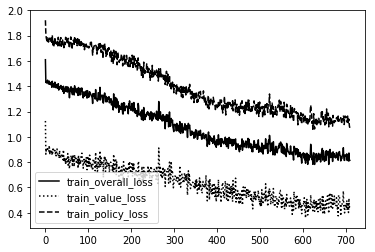




TOURNAMENT...
1 
2 
3 
4 
5 
6 
7 
8 
9 


KeyboardInterrupt: 

In [3]:
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=.      NEW LOG      =*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')

env = Game()

# If loading an existing neural network, copy the config file to root
if initialise.INITIAL_RUN_NUMBER != None:
    copyfile(run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + '/config.py', './config.py')

import config

######## LOAD MEMORIES IF NECESSARY ########

if initialise.INITIAL_MEMORY_VERSION == None:
    memory = Memory(config.MEMORY_SIZE)
else:
    print('LOADING MEMORY VERSION ' + str(initialise.INITIAL_MEMORY_VERSION) + '...')
    memory = pickle.load( open( run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + "/memory/memory" + str(initialise.INITIAL_MEMORY_VERSION).zfill(4) + ".p",   "rb" ) )

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural netwrok, set the weights from that model
if initialise.INITIAL_MODEL_VERSION != None:
    best_player_version  = initialise.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialise.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, initialise.INITIAL_RUN_NUMBER, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())
#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())

#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
#user_player = User('player1', env.state_size, env.action_size)
iteration = 0

while 1:

    iteration += 1
    importlib.reload(lg)
    importlib.reload(config)
    
    print('ITERATION NUMBER ' + str(iteration))
    
    lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## SELF PLAY ########
    print('SELF PLAYING ' + str(config.EPISODES) + ' EPISODES...')
    _, memory, _, _ = playMatches(best_player, best_player, config.EPISODES, lg.logger_main, turns_until_tau0 = config.TURNS_UNTIL_TAU0, memory = memory)
    print('\n')
    
    memory.clear_stmemory()
    
    if len(memory.ltmemory) >= config.MEMORY_SIZE:

        ######## RETRAINING ########
        print('RETRAINING...')
        current_player.replay(memory.ltmemory)
        print('')

        if iteration % 5 == 0:
            pickle.dump( memory, open( run_folder + "memory/memory" + str(iteration).zfill(4) + ".p", "wb" ) )

        lg.logger_memory.info('====================')
        lg.logger_memory.info('NEW MEMORIES')
        lg.logger_memory.info('====================')
        
        memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))
        
        for s in memory_samp:
            current_value, current_probs, _ = current_player.get_preds(s['state'])
            best_value, best_probs, _ = best_player.get_preds(s['state'])

            lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
            lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
            lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
            lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
            lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
            lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
            lg.logger_memory.info('ID: %s', s['state'].id)
            lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

            s['state'].render(lg.logger_memory)
            
        ######## TOURNAMENT ########
        print('TOURNAMENT...')
        scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney, turns_until_tau0 = 0, memory = None)
        print('\nSCORES')
        print(scores)
        print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
        print(sp_scores)
        #print(points)

        print('\n\n')

        if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
            best_player_version = best_player_version + 1
            best_NN.model.set_weights(current_NN.model.get_weights())
            best_NN.write(env.name, best_player_version)

    else:
        print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

In [5]:
from game import Game
from funcs import playMatchesBetweenVersions
import loggers as lg
env = Game()
playMatchesBetweenVersions(
env
, 1  # the run version number where the computer player is located
, 8 # the version number of the first player (-1 for human)
, 30 # the version number of the second player (-1 for human)
, 10 # how many games to play
, lg.logger_tourney # where to log the game to
, 0  # which player to go first - 0 for random
)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


({'drawn': 6, 'player1': 0, 'player2': 4},
 None,
 {'player1': [0, 0, -1, 0, -1, 0, 0, 0, -1, -1],
  'player2': [0, 0, -1, 0, -1, 0, 0, 0, -1, -1]},
 {'drawn': 6, 'nsp': 0, 'sp': 4})

In [9]:
sum([0.5, 0.3, 0.2] * np.log([0.5, 0.3, 0.2]))

-1.0296530140645737

In [10]:
sum([0.2, 0.3, 0.5] * np.log([0.5, 0.3, 0.2]))

-1.30454023362682

In [12]:
minimise = -99
for i in range(1, 10):
    for j in range(1, 10):
        for k in range(1, 10):
            a1 = i * 0.1
            a2 = j * 0.1
            a3 = k * 0.1
            if a1 + a2 + a3 == 1:
                similarity = sum([a1, a2, a3] * np.log([0.5, 0.3, 0.2]))
                if similarity > minimise:
                    minimise_a1 = a1
                    minimise_a2 = a2
                    minimise_a3 = a3
                    minimise = similarity
                    
print([minimise_a1, minimise_a2, minimise_a3], minimise)

[0.8, 0.1, 0.1] -0.8358588161239598
